# 特徴量相関分析 v2

**目的**: 数値特徴量間の相関とターゲットとの相関を分析

**このノートブックで行うこと**:
1. ターゲット変数との相関分析
2. 多重共線性の検出
3. 特徴量選択の示唆を得る

## セットアップ

In [1]:
import sys
import os
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# プロジェクトルートをパスに追加
project_root = Path().resolve().parent.parent
sys.path.insert(0, str(project_root / "04_src"))
os.chdir(project_root)

import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns

# フォント設定
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
try:
    import japanize_matplotlib
    japanize_matplotlib.japanize()
except ImportError:
    plt.rcParams['font.sans-serif'] = ['Hiragino Sans', 'Yu Gothic', 'Meiryo', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

# テスト済み関数のimport
from eda.correlation import calculate_correlations, find_high_correlation_pairs

print("✓ セットアップ完了")

✓ セットアップ完了


## 1. データ読み込み

In [2]:
# データ読み込み（DataLoaderパターン）
from data.loader import DataLoader
from utils.config import load_config

data_config = load_config("data")
loader = DataLoader(data_config)
train = loader.load_train()

print(f"訓練データ: {train.shape}")
train.head()

訓練データ: (363924, 149)


target_ym,money_room,building_id,building_status,building_create_date,building_modify_date,building_type,building_name,building_name_ruby,homes_building_name,homes_building_name_ruby,unit_count,full_address,lon,lat,building_structure,total_floor_area,building_area,floor_count,basement_floor_count,year_built,building_land_area,land_area_all,unit_area_min,unit_area_max,building_land_chimoku,land_youto,land_toshi,land_chisei,land_area_kind,land_setback_flg,land_setback,land_kenpei,land_youseki,land_road_cond,land_seigen,building_area_kind,…,money_shuuzen,money_shuuzenkikin,money_sonota_str1,money_sonota1,money_sonota_str2,money_sonota2,money_sonota_str3,money_sonota3,parking_money,parking_money_tax,parking_kubun,parking_distance,parking_number,parking_memo,genkyo_code,usable_status,usable_date,school_ele_name,school_ele_distance,school_ele_code,school_jun_name,school_jun_distance,school_jun_code,convenience_distance,super_distance,hospital_distance,park_distance,drugstore_distance,bank_distance,shopping_street_distance,est_other_name,est_other_distance,statuses,parking_keiyaku,money_hoshou_company,free_rent_duration,free_rent_gen_timing
i64,i64,i64,i64,str,str,i64,str,str,str,str,i64,str,f64,f64,i64,f64,f64,i64,i64,i64,f64,f64,f64,f64,i64,i64,i64,i64,i64,i64,f64,f64,f64,f64,str,i64,…,i64,i64,str,i64,str,i64,str,i64,i64,i64,i64,i64,i64,str,i64,i64,i64,str,i64,str,str,i64,str,i64,i64,i64,i64,i64,i64,i64,str,i64,str,i64,str,str,str
201901,13980000,206271,1,"""2014-06-27 21:09:41""","""2019-01-24 00:10:08""",4,null,null,"""桑名市東正和台7丁目10-11""",null,null,"""三重県桑名市東正和台7丁目10-11""",136.637467,35.047688,1,106.82,null,2,null,199204,188.490005,188.490005,null,null,1,1,1,null,1,null,null,50.0,80.0,null,null,1,…,null,null,null,null,null,null,null,null,0,null,1,null,2,null,2,1,null,"""桑部小学校""",2000,null,"""正和中学校""",2000,null,null,null,null,null,null,null,null,null,null,"""210101/220701/220601/230401/31…",null,null,null,null
201901,24480000,83315,1,"""2014-06-27 21:09:43""","""2019-04-03 00:10:08""",4,null,null,"""桑名市松ノ木5丁目""",null,1,"""三重県桑名市松ノ木5丁目14-8""",136.639936,35.074625,10,null,null,2,null,198108,290.519989,null,null,null,null,1,1,1,2,1,1.2,50.0,80.0,1.0,null,null,…,null,null,null,null,null,null,null,null,0,null,1,null,3,null,2,1,null,"""大山田南小学校""",350,null,"""陵成中学校""",1100,null,null,null,null,null,null,null,null,null,null,"""210101/220701/220601/220801/23…",null,null,null,null
201901,24480000,140201,1,"""2014-06-27 21:09:43""","""2020-06-06 00:10:11""",4,null,null,"""桑名市松ノ木七丁目""",null,1,"""三重県桑名市松ノ木7丁目16-10""",136.644708,35.072248,1,null,null,2,null,199506,235.649994,null,null,null,null,1,1,1,2,1,1.2,50.0,80.0,2.0,null,null,…,null,null,null,null,null,null,null,null,0,null,1,null,2,null,2,1,null,"""大山田南小学校""",850,null,"""陵成中学校""",1200,null,null,null,null,null,null,null,null,null,null,"""210101/220701/220601/230401/22…",null,null,null,null
201901,16300000,216551,1,"""2014-06-27 19:24:11""","""2019-04-26 00:10:08""",4,null,null,"""中古戸建 知多市八幡字荒井""",null,null,"""愛知県知多市八幡荒井105-1""",136.875602,35.003174,1,106.809998,null,2,null,200203,169.729996,null,null,null,1,12,1,null,1,1,null,60.0,200.0,null,"""準防火地域、文化財保護法""",null,…,0,null,null,null,null,null,null,null,0,null,1,0,3,null,1,2,null,"""八幡小学校""",1400,null,"""八幡中学校""",1400,null,null,null,null,null,null,null,null,"""コンビニ""",300,"""210101/290901/230401/210301/21…",null,null,null,null
201901,18800000,134968,1,"""2014-06-27 19:24:12""","""2025-09-15 02:49:23""",1,"""ロイヤル知多寺本""",null,"""ロイヤル知多寺本""",null,32,"""愛知県知多市八幡荒古後12-2""",136.875754,35.002403,4,76.739998,null,6,null,200703,null,null,null,null,null,3,1,null,null,1,null,60.0,200.0,null,"""準防火地域""",1,…,3670,null,null,null,null,null,null,null,3000,null,1,0,null,null,2,2,null,"""八幡小学校""",1080,null,"""八幡中学校""",1410,null,null,null,null,null,1060,null,null,"""駅""",300,"""220801/220401/250101/220701/32…",null,null,null,null


## 2. 数値カラムの抽出

In [3]:
# 数値カラムを抽出（Float64、Int64）
numeric_cols = [col for col in train.columns if train[col].dtype in [pl.Float64, pl.Int64]]

# ターゲット変数を除外
target_col = "money_room"
feature_cols = [col for col in numeric_cols if col != target_col]

print(f"数値カラム数: {len(numeric_cols)}")
print(f"特徴量カラム数: {len(feature_cols)}")
print(f"\n先頭10件: {feature_cols[:10]}")

数値カラム数: 98
特徴量カラム数: 97

先頭10件: ['target_ym', 'building_id', 'building_status', 'building_type', 'unit_count', 'lon', 'lat', 'building_structure', 'total_floor_area', 'building_area']


## 3. ターゲット変数との相関分析

In [4]:
# ターゲットとの相関を計算（テスト済み関数）
target_corr = calculate_correlations(train, target_col, feature_cols)

print("[ターゲット変数との相関 - 上位20件]")
print(target_corr.head(20))

[ターゲット変数との相関 - 上位20件]
shape: (20, 2)
┌──────────────────────────┬─────────────┐
│ feature                  ┆ correlation │
│ ---                      ┆ ---         │
│ str                      ┆ f64         │
╞══════════════════════════╪═════════════╡
│ traffic_car              ┆ 0.996619    │
│ money_rimawari_now       ┆ -0.536908   │
│ year_built               ┆ 0.332626    │
│ parking_money            ┆ 0.308021    │
│ room_floor               ┆ 0.295546    │
│ …                        ┆ …           │
│ school_ele_distance      ┆ -0.168659   │
│ hospital_distance        ┆ -0.16402    │
│ lon                      ┆ 0.163669    │
│ school_jun_distance      ┆ -0.163069   │
│ shopping_street_distance ┆ -0.162403   │
└──────────────────────────┴─────────────┘


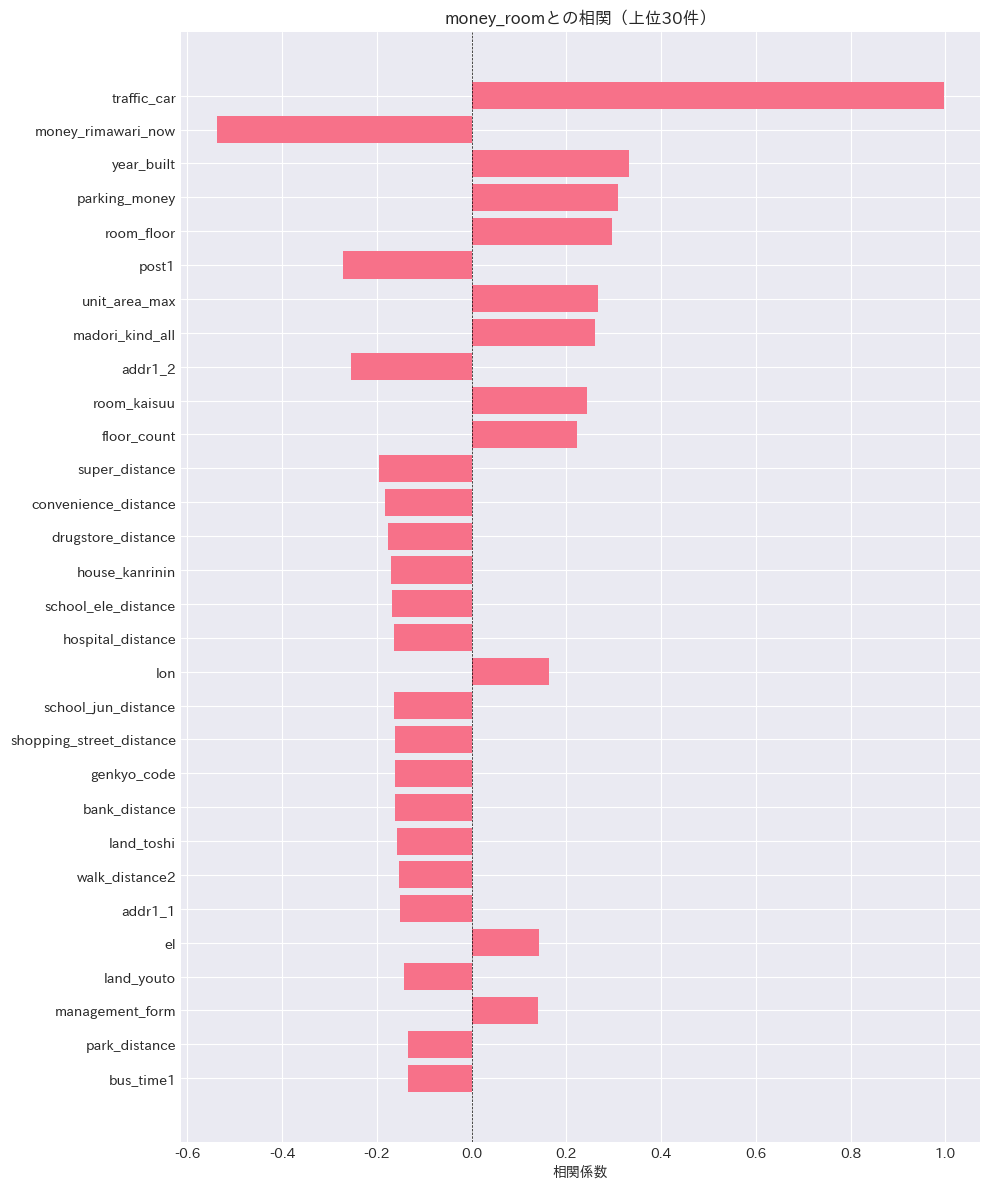

In [5]:
# 相関係数の可視化（上位30件）
top_30 = target_corr.head(30)

plt.figure(figsize=(10, 12))
plt.barh(range(len(top_30)), top_30['correlation'][::-1])
plt.yticks(range(len(top_30)), top_30['feature'][::-1])
plt.xlabel('相関係数')
plt.title(f'{target_col}との相関（上位30件）')
plt.axvline(x=0, color='k', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

## 4. 多重共線性の検出

In [6]:
# 高相関ペアの検出（閾値0.8）
high_corr_pairs = find_high_correlation_pairs(train, feature_cols, threshold=0.8)

print(f"[多重共線性の可能性があるペア: {len(high_corr_pairs)}件]")
if len(high_corr_pairs) > 0:
    for col1, col2, corr in high_corr_pairs[:20]:
        print(f"{col1:40s} - {col2:40s}: {corr:6.3f}")
else:
    print("多重共線性の可能性がある特徴量ペアは見つかりませんでした。")

[多重共線性の可能性があるペア: 46件]
building_id                              - traffic_car                             :  1.000
building_status                          - traffic_car                             : -1.000
lon                                      - traffic_car                             : -1.000
lat                                      - traffic_car                             : -1.000
floor_count                              - traffic_car                             :  1.000
year_built                               - traffic_car                             :  1.000
building_land_area                       - traffic_car                             :  1.000
land_youto                               - traffic_car                             : -1.000
land_toshi                               - traffic_car                             : -1.000
land_kenpei                              - traffic_car                             : -1.000
land_youseki                             - traffic_car    

## 5. 相関ヒートマップ（上位特徴量）

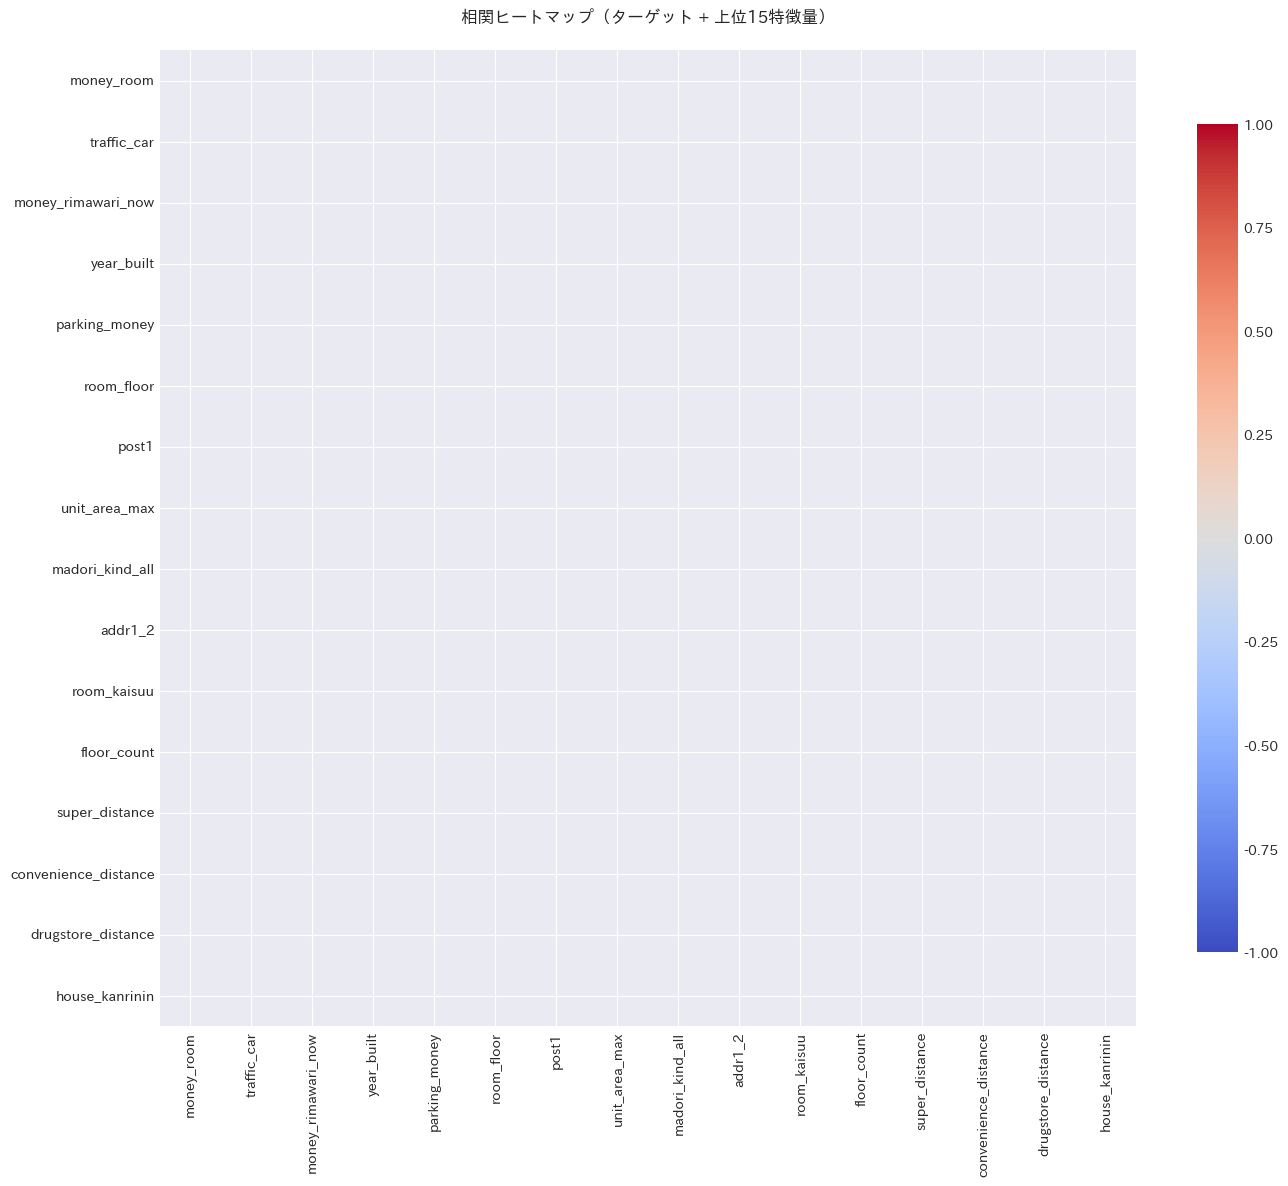

In [7]:
# ターゲットとの相関が高い上位15特徴量でヒートマップ
top_15_features = target_corr.head(15)['feature'].to_list()
selected_features = [target_col] + top_15_features

# Polarsで相関行列を計算
selected_df = train.select(selected_features).drop_nulls()

# NumPy配列に変換して相関行列を計算
import numpy as np
corr_matrix = np.corrcoef(selected_df.to_numpy(), rowvar=False)

# ヒートマップ作成
plt.figure(figsize=(14, 12))
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt='.2f',
    cmap='coolwarm',
    center=0,
    vmin=-1,
    vmax=1,
    xticklabels=selected_features,
    yticklabels=selected_features,
    square=True,
    cbar_kws={'shrink': 0.8}
)
plt.title('相関ヒートマップ（ターゲット + 上位15特徴量）', pad=20)
plt.tight_layout()
plt.show()

## 6. まとめ

### ターゲットとの相関
- **高相関特徴量（|r| > 0.5）**: [メモ]
- **中程度相関（0.3 < |r| < 0.5）**: [メモ]
- **低相関（|r| < 0.3）**: [メモ]

### 多重共線性
- **高相関ペア数**: X件
- **対応方針**: 
  - [ ] どちらか一方を削除
  - [ ] PCA等で次元削減
  - [ ] そのまま使用（tree-basedモデルは比較的頑健）

### 次のステップ
- [ ] カテゴリ変数の分析（04_categorical_analysis.ipynb）
- [ ] 地理空間分析（05_geospatial_analysis.ipynb）
- [ ] 特徴量エンジニアリング